<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/Transformer_Classiffier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

databank = pd.read_hdf("/content/drive/MyDrive/databank_updated", key="databank")

df = databank.copy()

Mounted at /content/drive


In [14]:
import torch
from torch.utils.data import Dataset
import numpy as np

class BinarySpectrumDataset(Dataset):
    def __init__(self, canonical_seq, truncated_seqs, spectra):
        """
        Args:
            canonical_seq (str): Full canonical amino acid sequence (e.g., from UniProt).
            truncated_seqs (List[str]): List of N- or C-terminal truncated sequences.
            spectra (List[np.ndarray]): List of 1D numpy arrays with shape (2000,) each.
        """
        self.canonical_seq = canonical_seq
        self.seq_len = len(canonical_seq)

        # Filter valid sequences
        valid_labels = []
        valid_spectra = []

        for t_seq, spec in zip(truncated_seqs, spectra):
            try:
                label = self._create_binary_mask(t_seq)
                valid_labels.append(label)
                valid_spectra.append(spec)
            except ValueError:
                print(f"[WARNING] Skipping invalid sequence: '{t_seq[:10]}...' not found in canonical sequence.")

        if not valid_spectra:
            raise ValueError("No valid truncated sequences matched the canonical sequence.")

        # Convert valid spectra to tensor of shape [n_samples, 2000]
        self.spectra = torch.tensor(np.stack(valid_spectra), dtype=torch.float32)
        self.labels = torch.stack(valid_labels)

    def _create_binary_mask(self, t_seq):
        """Generate a binary mask of length `seq_len` with 1s for matching region."""
        mask = torch.zeros(self.seq_len, dtype=torch.float32)
        start_idx = self.canonical_seq.find(t_seq)
        if start_idx == -1:
            raise ValueError(f"Truncated sequence '{t_seq}' not found in canonical sequence.")
        mask[start_idx:start_idx + len(t_seq)] = 1.0
        return mask

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.labels[idx]


In [15]:
# Assuming canonical sequence is known

# Filter the dataframe
spectra = []
truncated_sequence = []

for i in range(len(df)):
    if df['scan_type'][i] == 'MS2' and df['Uniprot ID'][i] == 'SYUA_HUMAN':
        spectra.append(np.array(df['cast spectra'][i]))  # Ensure it's np.array
        truncated_sequence.append(df['sequence'][i])

# Create dataset
canonical_seq = "MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA"  # update this

dataset = BinarySpectrumDataset(canonical_seq, truncated_sequence, spectra)


[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' not found in canonical sequence.
[WARNING] Skipping invalid sequence: 'MDVFMKGLSK...' n

In [16]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=140):  # max_len is the sequence length
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Transformer Model ---
class SpectrumToSequence(nn.Module):
    def __init__(self, input_dim=1600, seq_len=140):
        super().__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(input_dim, 256)
        self.encoder_pos_enc = PositionalEncoding1D(256, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, nhead=8, dim_feedforward=512, dropout=0.1, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.class_head = nn.Linear(256, 2)  # 2 classes: unmodified (0), modified (1)

    def forward(self, spectra):
        # spectra: [B, 1600]
        x = self.input_proj(spectra).unsqueeze(1).repeat(1, self.seq_len, 1)  # [B, 140, 256]
        x = self.encoder_pos_enc(x)
        x = self.encoder(x)
        return self.class_head(x)  # [B, 140, 2]

# --- Setup ---
SEQ_LEN = 140
SPECTRA_DIM = 1600

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrumToSequence(input_dim=SPECTRA_DIM, seq_len=SEQ_LEN).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


# --- Training ---
for epoch in range(100):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # [B, 140, 2]
        loss = loss_fn(logits.view(-1, 2), y.view(-1).long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# --- Evaluation ---
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=-1).cpu()
        all_preds.extend(preds.view(-1).tolist())
        all_true.extend(y.view(-1).tolist())

# --- Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Truncated", "Intact"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

# --- Accuracy ---
acc = (np.array(all_preds) == np.array(all_true)).mean()
print(f"\nTest Accuracy: {acc * 100:.2f}%")


Epoch 1: Loss = 0.3003
Test Accuracy after Epoch 1: 90.55%
Epoch 2: Loss = 0.2487
Test Accuracy after Epoch 2: 90.69%
Epoch 3: Loss = 0.2052
Test Accuracy after Epoch 3: 93.83%
Epoch 4: Loss = 0.1439
Test Accuracy after Epoch 4: 95.32%
Epoch 5: Loss = 0.0976
Test Accuracy after Epoch 5: 93.14%
Epoch 6: Loss = 0.0967
Test Accuracy after Epoch 6: 97.36%
Epoch 7: Loss = 0.0660
Test Accuracy after Epoch 7: 96.94%
Epoch 8: Loss = 0.0497
Test Accuracy after Epoch 8: 98.90%
Epoch 9: Loss = 0.0481
Test Accuracy after Epoch 9: 98.58%
Epoch 10: Loss = 0.0283
Test Accuracy after Epoch 10: 98.32%
Epoch 11: Loss = 0.0249
Test Accuracy after Epoch 11: 98.16%
Epoch 12: Loss = 0.0194
Test Accuracy after Epoch 12: 98.71%
Epoch 13: Loss = 0.0155
Test Accuracy after Epoch 13: 99.23%
Epoch 14: Loss = 0.0202
Test Accuracy after Epoch 14: 99.29%
Epoch 15: Loss = 0.0382
Test Accuracy after Epoch 15: 96.29%
Epoch 16: Loss = 0.0192
Test Accuracy after Epoch 16: 98.81%
Epoch 17: Loss = 0.0172
Test Accuracy afte

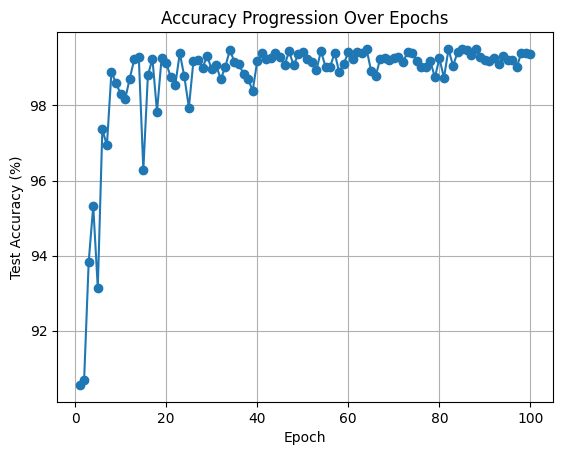

In [18]:
accuracies = []
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrumToSequence(input_dim=SPECTRA_DIM, seq_len=SEQ_LEN).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits.view(-1, 2), y.view(-1).long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss / len(train_loader):.4f}")

    # Evaluate every 5 epochs
    if epoch % 1 == 0:
        model.eval()
        all_preds = []
        all_true = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(DEVICE)
                logits = model(x)
                preds = logits.argmax(dim=-1).cpu()
                all_preds.extend(preds.view(-1).tolist())
                all_true.extend(y.view(-1).tolist())

        acc = (np.array(all_preds) == np.array(all_true)).mean()
        print(f"Test Accuracy after Epoch {epoch}: {acc * 100:.2f}%")
        accuracies.append((epoch, acc * 100))

# --- Optional: Plot Accuracy Progression ---
epochs, acc_vals = zip(*accuracies)
plt.figure()
plt.plot(epochs, acc_vals, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy Progression Over Epochs")
plt.grid(True)
plt.show()


In [40]:
# Put model in evaluation mode
model.eval()

# Get one batch from the test loader
x_test_batch, y_test_batch = next(iter(test_loader))
x_test_batch, y_test_batch = x_test_batch.to(DEVICE), y_test_batch.to(DEVICE)

# Forward pass
with torch.no_grad():
    logits = model(x_test_batch)  # [B, 140, 2]
    preds = logits.argmax(dim=-1)  # [B, 140]

# Choose a sample to visualize (e.g., first one in the batch)
idx = 7
pred_seq = preds[idx].cpu().numpy()         # Predicted: [140]
true_seq = y_test_batch[idx].cpu().numpy()  # Ground Truth: [140]

# Compare visually
print("Predicted Sequence:")
print("".join(["I" if x == 1 else "t" for x in pred_seq]))

print("\nTrue Sequence:")
print("".join(["I" if x == 1 else "t" for x in true_seq]))

# Optional: Show where predictions differ
mismatches = pred_seq != true_seq
print("\nMismatch at positions:")
print(np.where(mismatches)[0].tolist())


Predicted Sequence:
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

True Sequence:
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

Mismatch at positions:
[]
